In [1]:
import pandas as pd
import numpy as np

In [2]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

Using backend: pytorch


In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn import preprocessing

### Resources
https://www.kaggle.com/rounakbanik/the-movies-dataset<br>
https://docs.dgl.ai/en/0.6.x/generated/dgl.DGLHeteroGraph.ndata.html?highlight=ndata#dgl.DGLHeteroGraph.ndata<br>
https://docs.dgl.ai/en/0.6.x/generated/dgl.heterograph.html<br>
https://docs.dgl.ai/en/0.6.x/guide/message-heterograph.html<br>
https://docs.dgl.ai/en/0.6.x/tutorials/basics/5_hetero.html<br>

In [5]:
df = pd.read_csv('ratings.csv')

In [6]:
df.drop(columns=['timestamp'], inplace=True)

In [7]:
encoders = {
    'user': preprocessing.LabelEncoder(),
    'movie': preprocessing.LabelEncoder(),
}

In [8]:
df['encoded_user'] = encoders['user'].fit_transform(df.userId)
df['encoded_movie'] = encoders['movie'].fit_transform(df.movieId)

In [9]:
df['encoded_movie'].nunique()

9724

## Graph construction
Dataset`ratings_small`: rating as edge feature<br>
- user nodes will start at index `num_movies`

In [10]:
num_movies = df['encoded_movie'].nunique()

In [11]:
df['encoded_user'] = df['encoded_user'].apply(lambda x: x+num_movies)

In [12]:
g = dgl.graph((torch.tensor(pd.concat([df.encoded_user,df.encoded_movie]).tolist()), 
               torch.tensor(pd.concat([df.encoded_movie,df.encoded_user]).tolist())))

In [13]:
g.edata['rating'] = torch.tensor(pd.concat([df.rating,df.rating]).tolist())

## Training and test set
https://docs.dgl.ai/tutorials/blitz/4_link_predict.html?highlight=split%20edge%20set%20training%20testing

In [14]:
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)

# 20% test
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size


train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]

#### Negative sampling

In [15]:
# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [16]:
assert adj.todense()[neg_u,neg_v].all() == 0

In [17]:
train_g = dgl.remove_edges(g, eids[:test_size])

## GNN Definition

In [18]:
import dgl.function as fn

In [19]:
class CustomGNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        
        super(CustomGNN, self).__init__()
        
        # Weights
        self.user_w = nn.Parameter(torch.FloatTensor(in_dim,out_dim))
        self.movie_w = nn.Parameter(torch.FloatTensor(in_dim,out_dim))
        self.edge_w = nn.Parameter(torch.FloatTensor(1,out_dim))
            
        self.reset_parameters()
        
        
    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        
        #attention layer init
        nn.init.xavier_normal_(self.user_w, gain=gain)
        nn.init.xavier_normal_(self.movie_w, gain=gain)
        nn.init.xavier_normal_(self.edge_w, gain=gain)
        
    def forward(self, g, user_feat, movie_feat, edge_features):
        with g.local_scope():
            feat = torch.cat([movie_feat@self.movie_w, user_feat@self.user_w], dim=0)
            g.ndata['feat'] = feat
            g.edata['e_feat'] = edge_features.view(-1,1).float()@self.edge_w
            
            g.update_all(fn.u_mul_e('feat', 'e_feat', 'm'), fn.mean('m', 'h_out'))
            
            return g.ndata['h_out']

#### Continue link prediction: dgl
https://docs.dgl.ai/en/0.7.x/tutorials/blitz/4_link_predict.html<br>
https://docs.dgl.ai/en/0.6.x/_modules/dgl/nn/pytorch/hetero.html

In [24]:
from dgl.nn import SAGEConv

class CustomGraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(CustomGraphSAGE, self).__init__()
        self.conv = CustomGNN(in_feats, h_feats)
        self.conv1 = dgl.nn.SAGEConv(h_feats,h_feats, aggregator_type='mean')
        self.conv2 = dgl.nn.SAGEConv(h_feats,h_feats, aggregator_type='mean')
    
    def forward(self, g, user_feat, movie_feat, edge_features):
        
        h = self.conv(g, user_feat, movie_feat, edge_features)
        
        h = F.leaky_relu(self.conv1(g, h))
        h = self.conv2(g, h)
        
        return h

In [25]:
gnn = CustomGraphSAGE(128, 256)

---

#### Positive and Negative graph

In [26]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

#### Pred test

In [138]:
class DotPredictor(nn.Module):
    def forward(self, g, user_feat, movie_feat):
        u, v = g.edges()
        feat = torch.cat([movie_feat, user_feat],dim=0)
  
        dot = (feat[u]*feat[v]).sum(1)
        
        return dot
    
    def predict(self, nodes_u, nodes_v):
        return (nodes_u*nodes_v).sum(1)
    
    
class NeuralPredictor(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(2*hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1, bias=False),
        )
        
    
    def forward(self, g, feat):
        u, v = g.edges()
        
        
        score = self.mlp(torch.cat([feat[u], feat[v]], dim=1)).view(-1,)
        
        return score
    
    def predict(self, nodes_u, nodes_v):
        return self.mlp(torch.cat([nodes_u, nodes_v], dim=1)).view(-1,)

### Train loop

In [139]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [140]:


# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(hidden)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

def compute_recall(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    scores = torch.sigmoid(scores)
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return recall_score(labels, torch.round(scores))

def compute_precision(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    scores = torch.sigmoid(scores)
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return precision_score(labels, torch.round(scores))


In [170]:
def hits_at_k(pos_score, neg_score, k=20):
    scores = torch.sigmoid(torch.cat([pos_score, neg_score], dim=0))
    labels = torch.cat([torch.ones(pos_score.shape[0]),torch.zeros(neg_score.shape[0])],dim=0)
    
    top_k_idx = scores.topk(k).indices
    
    return labels[top_k_idx].mean().item()

In [216]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop

movie_feat = nn.Embedding(num_movies, 16)
user_feat = nn.Embedding(g.num_nodes()-num_movies, 16)
model = CustomGraphSAGE(16, 32)
#pred = DotPredictor()
pred = NeuralPredictor(32)

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), 
                                             pred.parameters(), 
                                             user_feat.parameters(), 
                                             movie_feat.parameters()), 
                             lr=0.01)

k = 50

# ----------- 4. training -------------------------------- #

for e in range(100):
    # forward
    h = model(train_g, user_feat.weight, movie_feat.weight, g.edata['rating'][eids[test_size:]])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    
    loss = compute_loss(pos_score, neg_score)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    h = model(g, user_feat.weight, movie_feat.weight, g.edata['rating'])
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))
    print('Recall', compute_recall(pos_score, neg_score))
    print('Precision', compute_precision(pos_score, neg_score))
    hits_k = hits_at_k(pos_score, neg_score, k)
    print(f"hits@k: {hits_k}")


# Thumbnail credits: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

In epoch 0, loss: 0.6972249150276184
In epoch 5, loss: 0.2691599726676941
In epoch 10, loss: 0.19730769097805023
In epoch 15, loss: 0.13522545993328094
In epoch 20, loss: 0.13125820457935333
In epoch 25, loss: 0.11696978658437729
In epoch 30, loss: 0.10937122255563736
In epoch 35, loss: 0.10251352936029434
In epoch 40, loss: 0.09360648691654205
In epoch 45, loss: 0.08685260266065598
In epoch 50, loss: 0.08355801552534103
In epoch 55, loss: 0.08095557242631912
In epoch 60, loss: 0.07815297693014145
In epoch 65, loss: 0.07586482912302017
In epoch 70, loss: 0.07390889525413513
In epoch 75, loss: 0.07209815084934235
In epoch 80, loss: 0.0709158182144165
In epoch 85, loss: 0.06882654130458832
In epoch 90, loss: 0.0664394348859787
In epoch 95, loss: 0.06497899442911148
AUC 0.9941402931576772
Recall 0.997966975752467
Precision 0.9585178835071677
hits@k: 0.9599999785423279


#### Validation testing

In [218]:
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    h = model(test_g, user_feat.weight, movie_feat.weight, g.edata['rating'][:test_size])
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))
    print('Recall', compute_recall(pos_score, neg_score))
    print('Precision', compute_precision(pos_score, neg_score))
    hits_k = hits_at_k(pos_score, neg_score, 250)
    print(f"hits@k: {hits_k}")

AUC 0.9673847683834822
Recall 0.9335548172757475
Precision 0.9336474088767667
hits@k: 0.8679999709129333


## Testing

#### Read movie data

In [219]:
df_movies = pd.read_csv('movies.csv')

#### Get embeddings

In [220]:
with torch.no_grad():
    features = model(g, user_feat.weight, movie_feat.weight, g.edata['rating'])

In [221]:
features.shape

torch.Size([10334, 32])

#### User id #0

In [238]:
idx = 0

user_emb = features[num_movies:][idx]

In [239]:
top_k_user = df[df.encoded_user == (idx+num_movies)][['movieId', 'rating']].sort_values('rating', ascending=False).iloc[:k]

### Recommended movies

In [240]:
prediction = torch.sigmoid(pred.predict(user_emb.view(1,-1).repeat(features[:num_movies].shape[0],1),features[:num_movies]))
prediction_index = prediction.topk(k).indices

<AxesSubplot:ylabel='Frequency'>

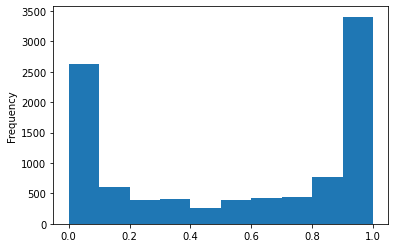

In [241]:
pd.Series(prediction.detach().numpy()).plot.hist()

#### Hits @ K for user

In [256]:
def user_metrics_at_k(user_ids, prediction_ids, k):
    num_relevant = len(np.intersect1d(user_ids, prediction_ids))
    
    print(num_relevant)
    print(k)
    print(user_ids.shape[0])
    
    precision_k = num_relevant/k
    recall_k = num_relevant/user_ids.shape[0]
    return precision_k, recall_k

In [257]:
user_movies = df[df.encoded_user == (idx+num_movies)][['movieId', 'rating']].sort_values('rating', ascending=False)['movieId']
recommended_movies = df_movies[df_movies.movieId.isin(encoders['movie'].inverse_transform(prediction_index))]['movieId']

In [264]:
precision_k, recall_k = user_metrics_at_k(user_movies,recommended_movies,k)

print(f"Precision@K for user: {precision_k}")
print(f"Recall@K for user: {recall_k}")

21
50
232
Precision@K for user: 0.42
Recall@K for user: 0.09051724137931035


In [245]:
df_movies[df_movies.movieId.isin(encoders['movie'].inverse_transform(prediction_index))]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
97,110,Braveheart (1995),Action|Drama|War
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
138,165,Die Hard: With a Vengeance (1995),Action|Crime|Thriller
176,208,Waterworld (1995),Action|Adventure|Sci-Fi
197,231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


In [246]:
df_movies[df_movies.movieId.isin(top_k_user.movieId)]

,movieId,title,genres
899,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
907,1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller
911,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
914,1213,Goodfellas (1990),Crime|Drama
921,1220,"Blues Brothers, The (1980)",Action|Comedy|Musical
923,1222,Full Metal Jacket (1987),Drama|War
925,1224,Henry V (1989),Action|Drama|Romance|War
927,1226,"Quiet Man, The (1952)",Drama|Romance
939,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller
955,1256,Duck Soup (1933),Comedy|Musical|War
